<a href="https://colab.research.google.com/github/darkfapper/Pandoras_Box/blob/main/Bayesian_Neural_Network_Pyro_Classification_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyro-ppl[funsor] torchsummary uncertainty-toolbox

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader , Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO , JitTrace_ELBO , Predictive
from pyro.infer.autoguide import (AutoDiagonalNormal , AutoMultivariateNormal ,
 AutoLaplaceApproximation , AutoNormal , AutoNormalizingFlow , AutoRegressiveMessenger,
 AutoNormalMessenger , AutoIAFNormal)
from pyro.distributions.transforms import block_autoregressive, iterated, affine_autoregressive , spline_autoregressive , affine_autoregressive
from pyro.infer.autoguide.gaussian import AutoGaussianFunsor
from tqdm.auto import trange
from scipy import stats as st
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score , roc_auc_score , brier_score_loss
from sklearn import datasets
from pyro.infer import MCMC, NUTS
import arviz as az
from functools import partial
from pyro.infer.reparam import NeuTraReparam
import pyro.poutine as poutine
from pyro.distributions.transforms import (neural_autoregressive ,spline_autoregressive , affine_autoregressive ,
affine_coupling , planar , conditional_affine_autoregressive, conditional_neural_autoregressive , ConditionalAffineAutoregressive)
torch.set_printoptions(precision=5,sci_mode=False)
# Set random seed for reproducibility
np.random.seed(42)
pyro.set_rng_seed(42)

from scipy import stats as st

In [ ]:
## Importando os dados
from google import colab
colab.drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/heart.csv")
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [ ]:
## Balanceamento das Classes

df["HeartDisease"].value_counts(normalize = True)

1    0.553377
0    0.446623
Name: HeartDisease, dtype: float64

In [ ]:
## Processamento dos dados

y =  df["HeartDisease"].values
X = df.drop(columns = ["HeartDisease"])



cat_cols = ["Sex","ChestPainType","RestingECG","ExerciseAngina","ST_Slope"]
num_cols = ["Age","RestingBP","Cholesterol","MaxHR","Oldpeak"]


#Separando as Vars
X = df.drop(columns = ["HeartDisease"])
y = df["HeartDisease"].values

## Preprocessado os Dados usando Sklearn
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

# X_pos = preprocessor.fit_(X)
# X_pos

In [ ]:
## Separando em Treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [ ]:
# Convert data to PyTorch tensors
X_train_mc = torch.from_numpy(X_train).float()
y_train_mc = torch.from_numpy(y_train).float()

X_test_mc = torch.from_numpy(X_test).float()
y_test_mc = torch.from_numpy(y_test).float()

batch_size = 512

In [ ]:
trainloader = DataLoader(list(zip(X_train_mc, y_train_mc)), shuffle=True, batch_size=batch_size)
validloader = DataLoader(list(zip(X_train_mc, y_train_mc)), shuffle=True, batch_size=len(X_train_mc))
testloader = DataLoader(list(zip(X_test_mc, y_test_mc)), shuffle=True, batch_size=len(X_test_mc))
loaders_dict = {"train": trainloader, "valid": validloader, "test": testloader}

In [ ]:
## Retirado da documentação do pacote

# Copyright (C) 2023 Intel Labs
#
# BSD-3-Clause License
#
# Redistribution and use in source and binary forms, with or without modification,
# are permitted provided that the following conditions are met:
# 1. Redistributions of source code must retain the above copyright notice,
#    this list of conditions and the following disclaimer.
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.
# 3. Neither the name of the copyright holder nor the names of its contributors
#    may be used to endorse or promote products derived from this software
#    without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO,
# THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
# ARE DISCLAIMED.  IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS
# BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY,
# OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT
# OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS;
# OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY,
# WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE
# OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE,
# EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
#
# Utily functions for variational inference in Bayesian deep neural networks
#
# @authors: Ranganath Krishnan
#
# ===============================================================================================



def entropy(prob):
    return -1 * np.sum(prob * np.log(prob + 1e-15), axis=0)


def predictive_entropy(mc_preds):
    """
    Compute the entropy of the mean of the predictive distribution
    obtained from Monte Carlo sampling during prediction phase.
    """
    return entropy(np.mean(mc_preds, axis=0))


def mutual_information(mc_preds):
    """
    Compute the difference between the entropy of the mean of the
    predictive distribution and the mean of the entropy.
    """
    mutual_info = entropy(np.mean(mc_preds, axis=0)) - np.mean(entropy(mc_preds),
                                                               axis=0)
    return mutual_info

In [ ]:
# from torchvision import transforms
# normalize = transforms.Normalize(0, 1)
# class SimpleDataset(Dataset):
#     # defining values in the constructor
#     def __init__(self, X, y, transform = None):
#         self.X = X
#         self.y = y
#         self.transform = transform

#     # Getting the data samples
#     def __getitem__(self, idx):
#         sample = self.x[idx], self.y[idx]
#         if self.transform:
#             sample = self.transform(sample)

#         return sample

#     # Getting data size/length
#     def __len__(self):
#         return self.len

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=X.shape[1], output_dim=1, hidden_dim=48, n_hidden_layers=3, use_dropout=False,p_dropout=0.25):
        super().__init__()

        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(p=p_dropout)
        self.activation = nn.LeakyReLU()

        # dynamically define architecture
        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = nn.ModuleList(layer_list)

    def forward(self, input):
        # input = input.reshape(1, -1)
        hidden = self.activation(self.layers[0](input))
        for layer in self.layers[1:-1]:
            hidden_temp = self.activation(layer(hidden))

            if self.use_dropout:
                hidden_temp = self.dropout(hidden_temp)

            hidden = hidden_temp + hidden  # residual connection

        output_mean = self.layers[-1](hidden).squeeze()
        return output_mean

In [ ]:
# class MyFirstBNN(PyroModule):
#     def __init__(self, in_dim=X.shape[1], out_dim=1, hid_dim=5, prior_scale=10.):
#         super().__init__()
#         self.activation = nn.LeakyReLU()  # or nn.ReLU()
#         self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
#         self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

#         # Set layer parameters as random variables
#         self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
#         self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
#         self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
#         self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

#     def forward(self, x, y=None):
#         x = self.activation(self.layer1(x))
#         ## Está em formato logito
#         mu = self.layer2(x).squeeze()
#         yhat = torch.nn.functional.sigmoid(mu)

#         # Sampling model
#         with pyro.plate("data", x.shape[0]):
#             probs = pyro.deterministic("probs",yhat)
#             obs = pyro.sample("obs", dist.Binomial(logits=mu), obs=y)
#         return mu

In [ ]:
class BNN(PyroModule):
    def __init__(self, in_dim=19, out_dim=1, hid_dim=48, n_hid_layers=3, prior_scale=10.):
        super().__init__()

        self.activation = nn.LeakyReLU()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        # x = x.reshape(x.shape[0], -1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        yhat = torch.nn.functional.sigmoid(mu)
        with pyro.plate("data", x.shape[0]):
            probs = pyro.deterministic("probs",yhat)
            ## Incerteza Aletorica
            obs = pyro.sample("obs", dist.Binomial(logits=mu), obs=y)
        return mu

In [ ]:
# # for i in range(X.shape[1]):
# #   X[:,i] = (X[:,i] - np.mean(X[:,i])) / np.std(X[:,i])

# sc_dict = {}
# for col in X_df.columns:
#   sc = StandardScaler()
#   X_df[col] = sc.fit_transform(X_df[col].values.reshape(-1,1))
#   sc_dict[col] = sc

In [ ]:
X , y = next(iter(loaders_dict["train"]))
X.shape

torch.Size([512, 19])

In [ ]:
loaders_dict["valid"].dataset[0][0]

tensor([ 0.35515,  2.52505,  0.78163, -0.67604, -0.10606,  0.00000,  1.00000,
         0.00000,  1.00000,  0.00000,  0.00000,  0.00000,  0.00000,  1.00000,
         1.00000,  0.00000,  0.00000,  1.00000,  0.00000])

In [ ]:
#Funções auxiliares

def entropy(prob):
    return -1 * np.sum(prob * np.log(prob + 1e-15), axis=0)


def without_keys(d, keys):
    return {k: v for k, v in d.items() if k not in keys}

# def func_metrics(samples,y):

#   # Caso Torch , converte para numpy
#   if torch.is_tensor(y):
#     y = y.detach().numpy()
#   if isinstance(samples,dict):
#     _preds = st.mode(samples["obs"].detach().numpy()).mode.ravel()
#     _preds_probs = np.mean(samples["probs"].detach().numpy(),0)
#   else:
#     _preds = np.where(samples > 0.5,1,0)
#     _preds_probs = samples
#   mean = np.mean(_preds_probs,axis = 0)
#   pred_entropy = predictive_entropy(_preds_probs)
#   mutual_info = mutual_information(_preds_probs)
#   acc = accuracy_score(y,_preds)
#   f1 = f1_score(y,_preds,average = "macro")
#   auc = roc_auc_score(y,mean)

#   return pd.DataFrame({"accuracy":acc,"f1":f1,"auc":auc,"predictive_entropy":pred_entropy,"mutual_information":mutual_info},index = [0])


def binary_cross_entropy(yhat: np.ndarray, y: np.ndarray) -> float:
    """Compute binary cross-entropy loss for a vector of predictions

    Parameters
    ----------
    yhat
        An array with len(yhat) predictions between [0, 1]
    y
        An array with len(y) labels where each is one of {0, 1}
    """

def func_metrics(samples,y):

  if isinstance(y,torch.Tensor):
    y = y.detach().numpy()
  if isinstance(samples,dict):
    _preds = st.mode(samples["obs"].detach().numpy()).mode.ravel()
    ## Existem valores negativos e acima de 1 (provavel erro de maquina)
    _preds_probs = np.clip(samples["probs"].detach().numpy(),0.0001,1)
    mean = np.mean(_preds_probs,axis = 0)
  else:
    _preds_probs = samples
    mean = np.mean(_preds_probs,axis = 0)

    _preds = np.where(mean > 0.5,1,0)
  pred_entropy = predictive_entropy(_preds_probs)
  mutual_info = mutual_information(_preds_probs)
  acc = accuracy_score(y,_preds)
  f1 = f1_score(y,_preds)
  auc = roc_auc_score(y,_preds)
  brier = brier_score_loss(y,mean)

  return pd.DataFrame({"accuracy":acc,"f1":f1,"auc":auc,"predictive_entropy":pred_entropy,
                       "mutual_information":mutual_info,"brier_score":brier},index = [0])



def variational_train(model,guide_,loaders_dict,epochs = 5,num_samples = 150):
  pyro.clear_param_store()
  guide = guide_(model)
  optimizer = pyro.optim.Adam({"lr": 0.001})
  svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

  progress_bar = trange(epochs)
  losses = []
  for epoch in progress_bar:
    for X_batch, y_batch in loaders_dict["train"]:
      loss = svi.step(X_batch, y_batch)
      loss = loss/len(loaders_dict["train"])
      losses.append(loss)
    progress_bar.set_description(f"ELBO: {loss}")
  losses_ = np.array(losses)
  z = np.abs(st.zscore(losses_))
  losses_ = losses_[z < 3]
  plt.plot(range(1,len(losses_)+1),losses_)
  plt.xlabel("Epochs")
  plt.ylabel("ELBO")
  plt.show()

  ## Avaliação da Predição

  list_metrics = []
  predictive = Predictive(model, guide=guide,num_samples=num_samples)
  for name_set, loader in without_keys(loaders_dict,"train").items():
    X , y = next(iter(loader))
    # X = X.cuda()
    samples = predictive(X)
    metrics = func_metrics(samples,y)
    metrics["guide"] = str(guide)
    metrics["model"] = str(model)
    metrics["name_set"] = name_set
    list_metrics.append(metrics)
  metrics_full = pd.concat(list_metrics,axis = 0)

  return {"predictive":predictive ,"metrics":metrics_full ,"hist_train":losses}

def neural_mcmc_train(model,loaders_dict,guide,epochs = 50,num_samples = 50,warmup_steps = 10 ):
  pyro.clear_param_store()
  ## First Step: Variacional Inference
  optimizer = pyro.optim.Adam({"lr": 0.001})
  svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

  progress_bar = trange(epochs)
  losses = []
  for epoch in progress_bar:
    for X_batch, y_batch in loaders_dict["train"]:
      loss = svi.step(X_batch, y_batch)
      loss = loss/len(loaders_dict["train"])
      losses.append(loss)
  losses_ = np.array(losses)
  z = np.abs(st.zscore(losses_))
  losses_ = losses_[z < 3]
  plt.plot(range(1,len(losses_)+1),losses_)
  plt.xlabel("Epochs")
  plt.ylabel("ELBO")
  plt.show()

  ## Second Step: Markov Chain Monte Carlo
  X_mc , y_mc = next(iter(loaders_dict["valid"]))
  neutra = NeuTraReparam(guide.requires_grad_(False))
  #neutra = NeuTraReparam(guide)
  model = poutine.reparam(model,config=lambda _: neutra)
  nuts_kernel = NUTS(model, jit_compile=False)
  mcmc = MCMC(nuts_kernel, num_samples=num_samples,warmup_steps=warmup_steps)
  mcmc.run(X_mc, y_mc)
  mcmc.summary()
  predictive = Predictive(model, posterior_samples=mcmc.get_samples(num_samples))

  posterior_samples = mcmc.get_samples(num_samples)
  posterior_predictive = Predictive(model, posterior_samples)(X_mc)
  prior = Predictive(model, num_samples=num_samples)(X_mc)
  pyro_data = az.from_pyro(mcmc,prior=prior,posterior_predictive=posterior_predictive)
  az.plot_trace(pyro_data)

  ## Avaliação da Predição

  list_metrics = []
  predictive = Predictive(model, guide=guide,num_samples=num_samples)
  for name_set, loader in without_keys(loaders_dict,"train").items():
    X , y = next(iter(loader))
    samples = predictive(X)
    metrics = func_metrics(samples,y)
    metrics["guide"] = str(guide)
    metrics["model"] = str(model)
    metrics["name_set"] = name_set
    list_metrics.append(metrics)
  metrics_full = pd.concat(list_metrics,axis = 0)

  return {"predictive":predictive ,"metrics":metrics_full ,"viz_data": pyro_data,"hist_train":losses}



def mcmc_train(model,X,y,arviz = True,num_samples = 150,warmup_steps = 50):

  pyro.clear_param_store()

  nuts_kernel = NUTS(model, jit_compile=True)
  mcmc = MCMC(nuts_kernel, num_samples=num_samples,warmup_steps=warmup_steps)
  mcmc.run(X, y)
  predictive = Predictive(model, posterior_samples=mcmc.get_samples(num_samples))

  posterior_samples = mcmc.get_samples(num_samples)
  posterior_predictive = Predictive(model, posterior_samples)(X)
  prior = Predictive(model, num_samples=num_samples)(X)
  pyro_data = az.from_pyro(mcmc,prior=prior,posterior_predictive=posterior_predictive)
  az.plot_trace(pyro_data)

  ## Avaliação da Predição

  list_metrics = []
  predictive = Predictive(model, guide=guide,num_samples=num_samples)
  for name_set, loader in without_keys(loaders_dict,"train").items():
    X , y = next(iter(loader))
    samples = predictive(X)
    metrics = func_metrics(samples,y)
    metrics["guide"] = str(guide)
    metrics["model"] = str(model)
    metrics["name_set"] = name_set
    list_metrics.append(metrics)
  metrics_full = pd.concat(list_metrics,axis = 0)

  return {"predictive":predictive ,"metrics":metrics_full ,"viz_data": pyro_data,"hist_train":None}


def deterministic_train(net, loaders_dict):
    optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    losses = []
    progress_bar = trange(500)
    for _ in progress_bar:
      for x_train, y_train in loaders_dict["train"]:
        optimizer.zero_grad()
        loss = criterion(y_train.float(), net(x_train))
        progress_bar.set_postfix(loss=f'{loss / x_train.shape[0]:.3f}')
        loss.backward()
        optimizer.step()
        losses.append(loss)

    ## Avaliação da Predição

    net.eval()
    list_metrics = []
    for name_set, loader in without_keys(loaders_dict,"train").items():
      X , y = next(iter(loader))
      preds = net(X)
      acc = accuracy_score(y,_preds)
      f1 = f1_score(y,_preds)
      auc = roc_auc_score(y,_preds)
      brier = brier_score_loss(y,preds)
      bce = binary_cross_entropy(preds,y)
      metrics = pd.DataFrame({"accuracy":acc,"f1":f1,"auc":auc,"brier_score":brier,"binary_cross_entropy":bce},index = [0])
      metrics["model"] = str(net)
      metrics["name_set"] = name_set
      metrics["guide"] = "deterministic"
      list_metrics.append(metrics)
    metrics_full = pd.concat(list_metrics,axis = 0)



    return {"predictive": net , "metrics":metrics_full,"hist_train": losses}

In [ ]:
list_results = []

In [ ]:
## Verificando a distribuição das classes
pd.DataFrame(y_train_mc.numpy()).value_counts(normalize = True)

1.0    0.533333
0.0    0.466667
dtype: float64

  0%|          | 0/150 [00:00<?, ?it/s]

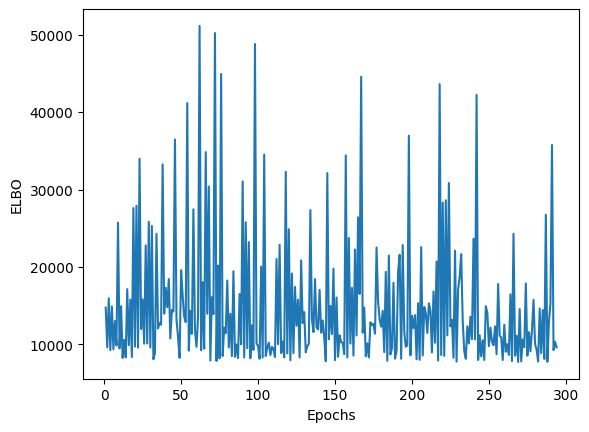

In [ ]:
## Baseline
model = BNN()
guide = AutoMultivariateNormal
aux = variational_train(model,guide,loaders_dict,epochs = 150,num_samples = 150)
# aux = neural_mcmc_train(model,loaders_dict)
aux["metrics"]
list_results.append(aux)

  0%|          | 0/150 [00:00<?, ?it/s]

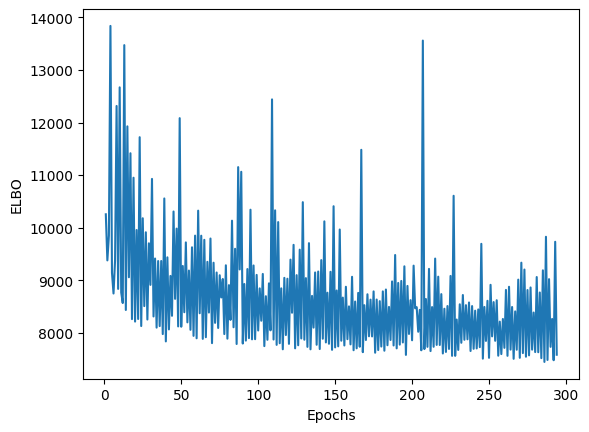

   accuracy        f1       auc  predictive_entropy  mutual_information  \
0  0.837398  0.859944  0.830357           92.258179           90.749829   
0  0.854785  0.877778  0.849458           48.523544           46.801757   

   brier_score                 guide  \
0     0.118214  AutoDiagonalNormal()   
0     0.104185  AutoDiagonalNormal()   

                                               model name_set  
0  BNN(\n  (activation): LeakyReLU(negative_slope...    valid  
0  BNN(\n  (activation): LeakyReLU(negative_slope...     test  


In [ ]:
## Baseline
model = BNN()
guide = AutoDiagonalNormal
aux = variational_train(model,guide,loaders_dict,epochs = 150,num_samples = 150)
#aux = neural_mcmc_train(model,loaders_dict)
print(aux["metrics"])
list_results.append(aux)

  0%|          | 0/150 [00:00<?, ?it/s]

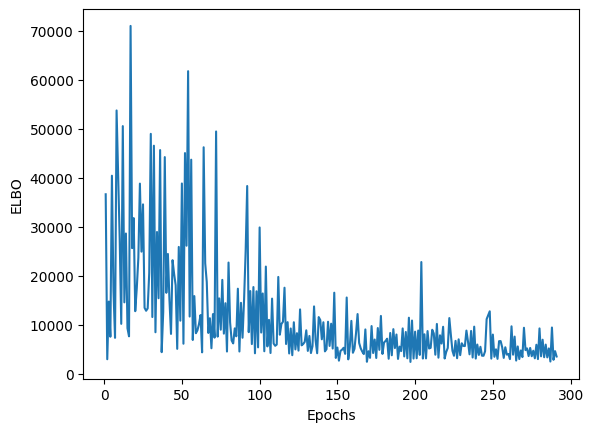

   accuracy        f1       auc  predictive_entropy  mutual_information  \
0  0.749593  0.740741  0.755226          212.262146          205.074986   
0  0.663366  0.722826  0.645867          102.240601           96.183172   

   brier_score                                              guide  \
0     0.229588  AutoNormalizingFlow(\n  (transform): ComposeTr...   
0     0.234672  AutoNormalizingFlow(\n  (transform): ComposeTr...   

                                               model name_set  
0  BNN(\n  (activation): LeakyReLU(negative_slope...    valid  
0  BNN(\n  (activation): LeakyReLU(negative_slope...     test  


In [23]:
model = BNN()
transform_init = partial(iterated,1,affine_autoregressive,stable = True)
guide = partial(AutoNormalizingFlow,init_transform_fn = transform_init)
aux = variational_train(model,guide,loaders_dict,epochs = 150,num_samples = 150)
print(aux["metrics"])
list_results.append(aux)

  0%|          | 0/150 [00:00<?, ?it/s]

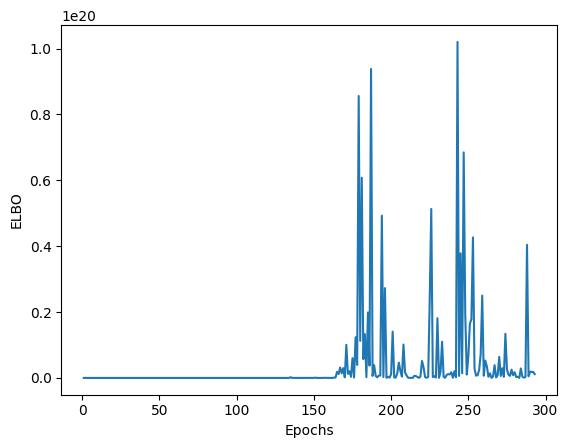

   accuracy        f1       auc  predictive_entropy  mutual_information  \
0  0.759350  0.739437  0.767857          208.601837          208.524506   
0  0.712871  0.710963  0.740312          101.743851          101.667338   

   brier_score                                              guide  \
0     0.188398  AutoIAFNormal(\n  (transform): ComposeTransfor...   
0     0.195932  AutoIAFNormal(\n  (transform): ComposeTransfor...   

                                               model name_set  
0  BNN(\n  (activation): LeakyReLU(negative_slope...    valid  
0  BNN(\n  (activation): LeakyReLU(negative_slope...     test  


In [24]:
model = BNN()
guide = partial(AutoIAFNormal,num_transforms = 3)
aux = variational_train(model,guide,loaders_dict,epochs = 150,num_samples = 150)
print(aux["metrics"])
list_results.append(aux)

In [ ]:
model = BNN()
transform_init = partial(iterated,1,neural_autoregressive,width = 4,activation = 'LeakyReLU')
guide = partial(AutoNormalizingFlow,init_transform_fn = transform_init)
aux = variational_train(model,guide,loaders_dict,epochs = 150,num_samples = 150)
print(aux["metrics"])
list_results.append(aux)

In [ ]:
# model = BNN()
# transform_init = partial(iterated,4,affine_autoregressive,stable = True)
# guide = partial(AutoNormalizingFlow,init_transform_fn = transform_init)
# aux = variational_train(model,guide,loaders_dict,epochs = 50,num_samples = 150)
# print(aux["metrics"])
# list_results.append(aux)

In [ ]:
# model = BNN()
# transform_init = partial(iterated,1,spline_autoregressive,count_bins = 4)
# guide = partial(AutoNormalizingFlow,init_transform_fn = transform_init)
# aux = variational_train(model,guide,loaders_dict,epochs = 50,num_samples = 150)
# print(aux["metrics"])
# list_results.append(aux)

In [ ]:
model = BNN()
transform_init = partial(iterated,2,affine_coupling)
guide = partial(AutoNormalizingFlow,init_transform_fn = transform_init)
aux = variational_train(model,guide,loaders_dict,epochs = 50,num_samples = 150)
print(aux["metrics"])
list_results.append(aux)

In [ ]:
pd.DataFrame(list_results[0])

In [ ]:
# from pyro.distributions.transforms import (neural_autoregressive ,spline_autoregressive , affine_autoregressive ,
# affine_coupling , planar , conditional_affine_autoregressive, conditional_neural_autoregressive , ConditionalAffineAutoregressive)
# input_dim = 19
# model = BNN()
# transform_init = partial(iterated,4,affine_autoregressive,stable = True)
# guide = partial(AutoNormalizingFlow,init_transform_fn = transform_init)
# res_dict = {"spline_autoregressive":{"base_fn":spline_autoregressive,"count_bins":4},
#             "affine_coupling":{"base_fn":affine_coupling,"hidden_dims":[20*input_dim]},
#             "neural_autoregressive":{"base_fn":neural_autoregressive,"width":8},
#             "affine_autoregressive":{"base_fn":affine_autoregressive,"stable" : True},
#             "conditional_affine_autoregressive":{"base_fn":conditional_affine_autoregressive,
#                                                  "context_dim": input_dim},}

# aux = variational_train(model,guide,loaders_dict,epochs = 250,num_samples = 150)
# aux["metrics"]

In [ ]:
# from pyro.distributions.transforms import (neural_autoregressive ,spline_autoregressive , affine_autoregressive ,
# affine_coupling , planar , conditional_affine_autoregressive, conditional_neural_autoregressive , ConditionalAffineAutoregressive)
# input_dim = 19
# model = BNN(in_dim = input_dim , hid_dim=64, n_hid_layers = 5)
# transform_init = partial(iterated,5,planar)
# guide = partial(AutoNormalizingFlow,init_transform_fn = transform_init)
# res_dict = {"spline_autoregressive":{"base_fn":spline_autoregressive,"count_bins":4},
#             "affine_coupling":{"base_fn":affine_coupling,"hidden_dims":[20*input_dim]},
#             "neural_autoregressive":{"base_fn":neural_autoregressive,"width":8},
#             "affine_autoregressive":{"base_fn":affine_autoregressive},
#             "conditional_affine_autoregressive":{"base_fn":conditional_affine_autoregressive,
#                                                  "context_dim": input_dim},}

# aux = variational_train(model,guide,loaders_dict,epochs = 250,num_samples = 150)
# aux["metrics"]

In [ ]:
ensemble_size = 3
ensemble = [MLP() for _ in range(ensemble_size)]
ensemble = [deterministic_train(net, loaders_dict) for net in ensemble]


In [ ]:
## Implementação usando Ensemble de Modelos
## entropia preditiva muito menor , repostas muito parecidas
ensemble_preds = [net(X_test_mc).clone().detach() for net in ensemble]
ensemble_preds = np.clip(torch.stack(ensemble_preds, dim=0).detach().numpy(),0,1)
mean = np.mean(ensemble_preds, axis=0)
_preds = np.where(mean > 0.5, 1, 0)
pred_entropy = predictive_entropy(ensemble_preds.T)
mutual_info = mutual_information(ensemble_preds.T)
acc = accuracy_score(y_test_mc,_preds)
f1 = f1_score(y_test_mc,_preds)
auc = roc_auc_score(y_test_mc,mean)
pd.DataFrame({"accuracy":acc,"f1":f1,"auc":auc,"predictive_entropy":pred_entropy,"mutual_information":mutual_info},index = [0])


In [ ]:
## Implementação usando Dropout

net_dropout = MLP(hidden_dim=30, n_hidden_layers=2, use_dropout=True)
net_dropout = deterministic_train(net_dropout, loaders_dict)

In [ ]:
n_dropout_samples = 100

# compute predictions, resampling dropout mask for each forward pass
dropout_preds = [net_dropout(X_train_mc).clone().detach().numpy() for _ in range(n_dropout_samples)]
dropout_preds = np.clip(np.array(dropout_preds),0,1)
mean = np.mean(dropout_preds, axis=0)
_preds = np.where(mean > 0.5, 1, 0)
pred_entropy = predictive_entropy(dropout_preds.T)
mutual_info = mutual_information(dropout_preds.T)
acc = accuracy_score(y_train_mc,_preds)
f1 = f1_score(y_train_mc,_preds)
auc = roc_auc_score(y_train_mc,mean)
result = pd.DataFrame({"accuracy":acc,"f1":f1,"auc":auc,"predictive_entropy":pred_entropy,"mutual_information":mutual_info},index = [0])
list_results.append(result)

In [ ]:
df_results = pd.DataFrame(list_results)
df_results

In [ ]:
## Criar um codigo para descompactar a lista de resultados
for result in list_results:
  print(result)